<a href="https://colab.research.google.com/github/ipeirotis/sql_autograding/blob/main/Evaluation_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth

# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [27]:
from google.colab import files
import io
import pandas as pd
import seaborn as sns

In [3]:
import gcsfs

fs = gcsfs.GCSFileSystem(project="sql_autograding")
with fs.open("gs://sql_autograding/completion.csv") as f:
    data = pd.read_csv(f)

In [4]:
data = data.drop(columns='Unnamed: 0')
data.head()

,BSpace Course Name,BSpace Course Id,QuizName,﻿QuizId,QuizAttemptNumber,QuestionId,Question,QuestionType,InputUserAnswer,Score,...,full_score,feedback,schema,0_mp,4_answer,4_grade,4_feedback,3_answer,3_grade,3_feedback
0,"Databases for Business Analytics, Winter 2023","251,683",Final Exam,"283,453",1,"4,969,729",Hard question. Requires use of subqueries and ...,Long Answer Question,"SELECT \n A.CustomerID,\n A.CompanyName,...",10.0,...,10.0,The feedback from the TA was Results for ident...,"([{'Categories': ['CategoryID', 'CategoryName'...",\n a. We are working with the ['northwi...,Grade: 9/10\n\nFeedback: Your answer is almost...,9,Your answer is almost perfect. You have correc...,Grade: 7/10\n\nFeedback: \n- The student's que...,7,\n- The student's query is mostly correct and ...
1,"Databases for Business Analytics, Winter 2023","251,683",Final Exam,"283,453",1,"4,969,713","For each order, show the customerID who placed...",Long Answer Question,"Select O.OrderID, O.CustomerID, Count(D.Produ...",5.5,...,10.0,The feedback from the TA was -3 pts for lack f...,"([{'Categories': ['CategoryID', 'CategoryName'...",\n a. We are working with the ['northwi...,Grade: 8/10\n\nFeedback: Your SQL query is mos...,8,Your SQL query is mostly correct and it shows ...,Grade: 8/10\n\nFeedback: \n- The student corre...,8,\n- The student correctly joins the Orders and...
2,"Databases for Business Analytics, Winter 2023","251,683",Final Exam,"283,453",1,"4,969,711",We want to identify the ship countries with th...,Long Answer Question,"use northwind;\nSELECT \n ShipCountry, AVG(...",7.0,...,7.5,"The feedback from the TA was It is ""LIMIT 3"" n...","([{'Categories': ['CategoryID', 'CategoryName'...",\n a. We are working with the ['northwi...,Grade: 9/10\n\nFeedback: Your SQL query is alm...,9,Your SQL query is almost perfect. You have cor...,Grade: 7/10\n\nFeedback: \n- The query provide...,7,\n- The query provided by the student is almos...
3,"Databases for Business Analytics, Winter 2023","251,683",Final Exam,"283,453",1,"4,969,710",For every customer in the database list the nu...,Long Answer Question,"Select C.CompanyName, C.CustomerID, sum(case w...",10.0,...,10.0,NaN,"([{'Categories': ['CategoryID', 'CategoryName'...",\n a. We are working with the ['northwi...,Grade: 10/10\n\nFeedback: Excellent job! Your ...,10,Excellent job! Your query correctly retrieves ...,Grade: 8/10\n\nFeedback: \n- The query provide...,8,\n- The query provided by the student is corre...
4,"Databases for Business Analytics, Winter 2023","251,683",Final Exam,"283,453",1,"4,969,709",Show the date/time of the first order ever dat...,Long Answer Question,use northwind;\nSELECT \n min(OrderDate) as...,7.5,...,7.5,NaN,"([{'Categories': ['CategoryID', 'CategoryName'...",\n a. We are working with the ['northwi...,Grade: 10/10\n\nFeedback: Great job! Your SQL ...,10,Great job! Your SQL query correctly retrieves ...,Grade: 8/10\n\nFeedback: \n- The query provide...,8,\n- The query provided by the student is corre...


## Parsing GPT Answer to Grade & Feedback for Zero-shot (when answers are strings)

In [5]:
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

In [6]:
def parse4(text):
  grade = 0
  f = text.split('.')[0].split(' ')
  for i,w in enumerate(f):
    if w == "out" and i > 0:
      grade = f[i-1]
      break

  feedback = text.split('.')[1:]
  return grade, feedback

In [7]:
def parse3(text):
  grade_start = text.find("Grade: ") + len("Grade: ")
  grade_end = text.find("/", grade_start)
  grade = text[grade_start:grade_end]

  feedback_start = text.find("Feedback: ") + len("Feedback: ")
  feedback = text[feedback_start:]
  return grade, feedback


In [8]:
for i,r in data.iterrows():
  if is_float(r['4_grade'])==False:
    g,f = parse4(r['4_answer'])
    data.at[i,'4_grade'] = g
    data.at[i,'4_feedback'] = f
  elif is_float(r['3_grade'])==False:
    g,f = parse3(r['3_answer'])
    data.at[i,'3_grade'] = g
    data.at[i,'3_feedback'] = f

In [9]:
data['3_grade'].value_counts()

8     2010
9      820
7      642
6      119
5       22
10      19
4       11
3        2
2        1
Name: 3_grade, dtype: int64

In [10]:
df = data[['QuestionId', 'Score', 'Database', 'full_score', '4_grade', '3_grade']]
df.head()

,QuestionId,Score,Database,full_score,4_grade,3_grade
0,"4,969,729",10.0,"['northwind', 'flights']",10.0,9,7
1,"4,969,713",5.5,"['northwind', 'flights']",10.0,8,8
2,"4,969,711",7.0,"['northwind', 'flights']",7.5,9,7
3,"4,969,710",10.0,"['northwind', 'flights']",10.0,10,8
4,"4,969,709",7.5,"['northwind', 'flights']",7.5,10,8


In [11]:
# scale gpt score
df['4_grade'] = (df['4_grade'].astype(float))*(df['full_score'].astype(float))/10
df['3_grade'] = (df['3_grade'].astype(float))*(df['full_score'].astype(float))/10
df.head()

<ipython-input-11-d307e72e2cc2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['4_grade'] = (df['4_grade'].astype(float))*(df['full_score'].astype(float))/10
<ipython-input-11-d307e72e2cc2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['3_grade'] = (df['3_grade'].astype(float))*(df['full_score'].astype(float))/10


,QuestionId,Score,Database,full_score,4_grade,3_grade
0,"4,969,729",10.0,"['northwind', 'flights']",10.0,9.00,7.00
1,"4,969,713",5.5,"['northwind', 'flights']",10.0,8.00,8.00
2,"4,969,711",7.0,"['northwind', 'flights']",7.5,6.75,5.25
3,"4,969,710",10.0,"['northwind', 'flights']",10.0,10.00,8.00
4,"4,969,709",7.5,"['northwind', 'flights']",7.5,7.50,6.00


In [12]:
df['4_error'] = ((df['Score'] - df['4_grade']).abs() / (df['Score']+df['4_grade'])/2)
df['3_error'] = ((df['Score'] - df['3_grade']).abs() / (df['Score']+df['3_grade'])/2)
# .map('{:.2%}'.format)
df.head()

<ipython-input-12-05deb3f40f0f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['4_error'] = ((df['Score'] - df['4_grade']).abs() / (df['Score']+df['4_grade'])/2)
<ipython-input-12-05deb3f40f0f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['3_error'] = ((df['Score'] - df['3_grade']).abs() / (df['Score']+df['3_grade'])/2)


,QuestionId,Score,Database,full_score,4_grade,3_grade,4_error,3_error
0,"4,969,729",10.0,"['northwind', 'flights']",10.0,9.00,7.00,0.026316,0.088235
1,"4,969,713",5.5,"['northwind', 'flights']",10.0,8.00,8.00,0.092593,0.092593
2,"4,969,711",7.0,"['northwind', 'flights']",7.5,6.75,5.25,0.009091,0.071429
3,"4,969,710",10.0,"['northwind', 'flights']",10.0,10.00,8.00,0.000000,0.055556
4,"4,969,709",7.5,"['northwind', 'flights']",7.5,7.50,6.00,0.000000,0.055556


In [13]:
df[['4_error', '3_error']].describe()

,4_error,3_error
count,3645.000000,3646.000000
mean,0.029580,0.053757
std,0.062593,0.028849
min,0.000000,0.000000
25%,0.000000,0.026316
50%,0.000000,0.055556
75%,0.026316,0.055556
max,0.500000,0.340000


In [14]:
dbs = df['Database'].unique()
error_lst_4 = []
error_lst_3 = []
for db in dbs:
  temp = df[df['Database']==db]
  error_lst_4.append(temp['4_error'].mean())
  error_lst_3.append(temp['3_error'].mean())
print(error_lst_4)

[0.026224655114074454, 0.024043097193701287, 0.029837453537246355, 0.08003734038312549]


In [15]:
print(error_lst_3)

[0.05194024078729233, 0.05089854423109014, 0.06423984063975988, 0.07394207143719624]


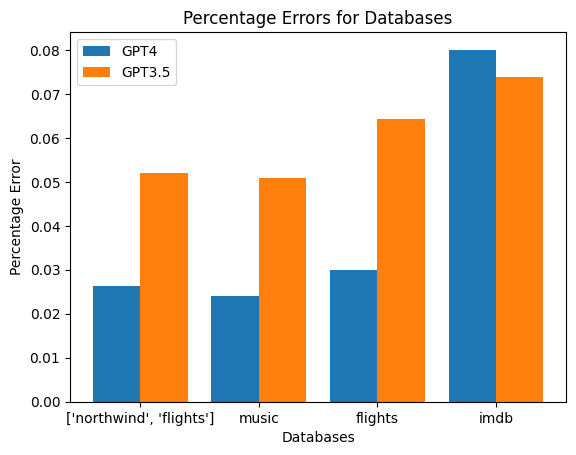

In [16]:
import matplotlib.pyplot as plt
import numpy as np

X_axis = np.arange(len(dbs))

plt.bar(X_axis - 0.2, error_lst_4, 0.4, label = 'GPT4')
plt.bar(X_axis + 0.2, error_lst_3, 0.4, label = 'GPT3.5')

plt.xticks(X_axis, dbs)
plt.xlabel("Databases")
plt.ylabel("Percentage Error")
plt.title("Percentage Errors for Databases")
plt.legend()
plt.show()

## Parsing GPT Answer to Grade & Feedback for Few-shot (when answers are JSON objects)

In [17]:
fs = gcsfs.GCSFileSystem(project="sql_autograding")
with fs.open("gs://sql_autograding/few_shots_completion.csv") as f:
    data = pd.read_csv(f)

In [18]:
data = data.drop(columns='Unnamed: 0')
data.head()

,index,BSpace Course Name,BSpace Course Id,QuizName,﻿QuizId,QuizAttemptNumber,QuestionId,Question,QuestionType,InputUserAnswer,...,schema,4_few_mp,num,4_answer,3_few_mp,4_grade,3_answer,4_feedback,3_grade,3_feedback
0,2028,"Databases for Business Analytics, MSQM SU23","277,478",Assignment 4: Aggregations,"301,300",1,"5,119,728",Count the number of tracks in the database,Long Answer Question,SELECT COUNT(*)\nFROM track;,...,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2473,"[{""grade"": ""10"", ""feedback"": ""Your answer is c...",\n a. We are working with the music datab...,10,"[{""grade"": ""10"", ""feedback"": ""Great job! Your ...",Your answer is correct. Good job!,10,Great job! Your answer is correct and concise.
1,909,"Databases for Business Analytics, Spring'23","251,685",Assignment 2B: Selection Queries,"295,300",1,"5,119,647",Show all the albums.,Long Answer Question,select * from album;,...,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2498,"[{""grade"": ""10"", ""feedback"": ""Your answer is c...",\n a. We are working with the music datab...,10,"[{""grade"": ""10"", ""feedback"": ""The student's an...",Your answer is correct. Good job!,10,The student's answer is correct. They selected...
2,3308,"Databases for Business Analytics, MSQM SU23","277,478",Assignment 5: Advanced Queries,"301,301",1,"5,119,787","As a first step, limit your analysis only to f...",Long Answer Question,DROP TABLE IF EXISTS eligible_names;\n\nCREATE...,...,"[{'actors': ['id', 'first_name', 'last_name', ...",\n a. We are working with the imdb databa...,2373,"[{""grade"": ""9.5"", ""feedback"": ""Your answer is ...",\n a. We are working with the imdb databa...,9.5,"[{""grade"": ""1.0"", ""feedback"": ""The student's a...","Your answer is almost perfect. However, the qu...",1.0,The student's answer is correct and follows th...
3,292,"Databases for Business Analytics, MSQM SU23","277,478",Assignment 2C: Filtering Queries,"301,294",1,"5,119,680","Find all the tracks that include the word ""Lov...",Long Answer Question,show databases;\nUSE music;\nSHOW Tables;\nSEL...,...,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2005,"[{""grade"": ""10"", ""feedback"": ""Your answer is c...",\n a. We are working with the music datab...,10,"[{""grade"": ""1.0"", ""feedback"": ""The query is co...",Your answer is correct. You have successfully ...,1.0,The query is correct and returns the desired r...
4,1954,"Databases for Business Analytics, Winter 2023","251,683",Final Exam,"283,453",1,"4,969,710",For every customer in the database list the nu...,Long Answer Question,"SELECT CustomerID, Count(OrderID) As NumOrders...",...,"([{'Categories': ['CategoryID', 'CategoryName'...",\n a. We are working with the ['northwind...,2395,"[{""grade"": ""8/10"", ""feedback"": ""Your query is ...",\n a. We are working with the ['northwind...,8/10,"[{""grade"": ""8.0"", ""feedback"": ""The query provi...",Your query is correct and it returns the expec...,8.0,The query provided by the student is correct a...


In [19]:
data['4_grade'].value_counts()

10          211
10/10        38
7.5/10        8
9.5           7
8/10          4
8.0           4
8.5/10        4
5/10          3
0.7           2
9.0           2
1.0           2
7/10          1
6.5/10        1
4.0/10.0      1
0.8           1
7.5           1
9.5/10        1
7.0/10        1
9/10          1
5.0/10        1
9.0/10        1
1.8/2.0       1
5.5/10        1
6.0/10.0      1
3.5/10        1
Name: 4_grade, dtype: int64

In [20]:
data.loc[120,'4_grade'] = 9
data.loc[120,'4_feedback'] = "Your answer is almost perfect. You correctly grouped by the origin and calculated the average fare and average distance. However, for the average fare per mile, you should use the 'fare_per_mile' column directly instead of calculating it as 'fare / distance'. Your query should look like this:\n\nSELECT origin,\n  AVG(fare) AS avg_fare,\n  AVG(fare_per_mile) AS avg_fare_per_mile,\n  AVG(distance) AS avg_distance\nFROM m_ticket_prices\nGROUP BY origin\nORDER BY origin;\n\nKeep up the good work!"

In [21]:
df = data[['QuestionId', 'Score', 'Database', 'full_score', '4_grade', '3_grade']]
df.head()

,QuestionId,Score,Database,full_score,4_grade,3_grade
0,"5,119,728",1.0,music,1.0,10,10
1,"5,119,647",1.0,music,1.0,10,10
2,"5,119,787",1.0,imdb,2.0,9.5,1.0
3,"5,119,680",1.0,music,1.0,10,1.0
4,"4,969,710",8.0,"['northwind', 'flights']",10.0,8/10,8.0


In [22]:
# scale gpt score

def scale_score(gpt_score, full_score):
  if str(gpt_score).endswith("/10") or str(gpt_score).endswith("/10.0") or str(gpt_score).endswith("/2.0"):
    numerator, denominator = map(float, gpt_score.split('/'))
    g = float(numerator)/float(denominator)
    return g*full_score
  else:
    return (float(gpt_score)*full_score)/10

In [23]:
lst4 = []
lst3 = []
for i, r in df.iterrows():
  grade4 = scale_score(r['4_grade'], r['full_score'])
  grade3 = scale_score(r['3_grade'], r['full_score'])
  lst4.append(grade4)
  lst3.append(grade3)

df['4_grade_scaled'] = lst4
df['3_grade_scaled'] = lst3
df.head()

<ipython-input-23-45a21b99034f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['4_grade_scaled'] = lst4
<ipython-input-23-45a21b99034f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['3_grade_scaled'] = lst3


,QuestionId,Score,Database,full_score,4_grade,3_grade,4_grade_scaled,3_grade_scaled
0,"5,119,728",1.0,music,1.0,10,10,1.0,1.0
1,"5,119,647",1.0,music,1.0,10,10,1.0,1.0
2,"5,119,787",1.0,imdb,2.0,9.5,1.0,1.9,0.2
3,"5,119,680",1.0,music,1.0,10,1.0,1.0,0.1
4,"4,969,710",8.0,"['northwind', 'flights']",10.0,8/10,8.0,8.0,8.0


In [24]:
df['4_error'] = ((df['Score'] - df['4_grade_scaled']).abs() / (df['Score']+df['4_grade_scaled'])/2)
df['3_error'] = ((df['Score'] - df['3_grade_scaled']).abs() / (df['Score']+df['3_grade_scaled'])/2)
# .map('{:.2%}'.format)
df.head()

<ipython-input-24-688b54a6d895>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['4_error'] = ((df['Score'] - df['4_grade_scaled']).abs() / (df['Score']+df['4_grade_scaled'])/2)
<ipython-input-24-688b54a6d895>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['3_error'] = ((df['Score'] - df['3_grade_scaled']).abs() / (df['Score']+df['3_grade_scaled'])/2)


,QuestionId,Score,Database,full_score,4_grade,3_grade,4_grade_scaled,3_grade_scaled,4_error,3_error
0,"5,119,728",1.0,music,1.0,10,10,1.0,1.0,0.000000,0.000000
1,"5,119,647",1.0,music,1.0,10,10,1.0,1.0,0.000000,0.000000
2,"5,119,787",1.0,imdb,2.0,9.5,1.0,1.9,0.2,0.155172,0.333333
3,"5,119,680",1.0,music,1.0,10,1.0,1.0,0.1,0.000000,0.409091
4,"4,969,710",8.0,"['northwind', 'flights']",10.0,8/10,8.0,8.0,8.0,0.000000,0.000000


In [28]:
df[['4_error', '3_error']].describe()

,4_error,3_error
count,300.000000,299.000000
mean,0.021086,0.131908
std,0.061797,0.176912
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.012821
75%,0.000000,0.363125
max,0.434579,0.452381


<Axes: >

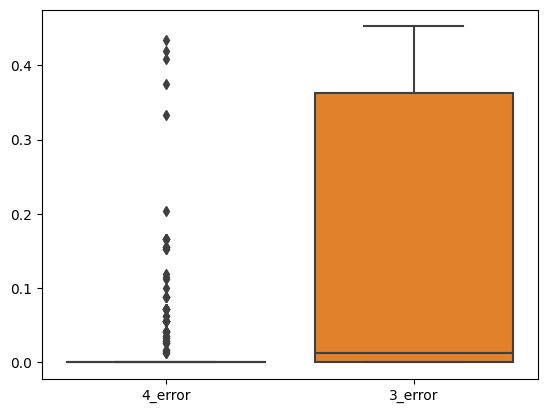

In [29]:
sns.boxplot(df[['4_error', '3_error']])

In [30]:
dbs = df['Database'].unique()
error_lst_4 = []
error_lst_3 = []
for db in dbs:
  temp = df[df['Database']==db]
  error_lst_4.append(temp['4_error'].mean())
  error_lst_3.append(temp['3_error'].mean())
print(error_lst_4)
print(error_lst_3)

[0.014181834614678859, 0.07112989446101828, 0.02715581406912545, 0.016869095816464237]
[0.13475144784126028, 0.32771464803594336, 0.06092871749631595, 0.03857428857428857]


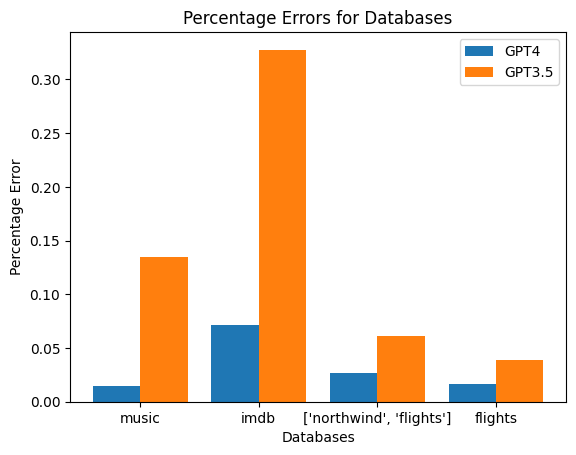

In [31]:
X_axis = np.arange(len(dbs))

plt.bar(X_axis - 0.2, error_lst_4, 0.4, label = 'GPT4')
plt.bar(X_axis + 0.2, error_lst_3, 0.4, label = 'GPT3.5')

plt.xticks(X_axis, dbs)
plt.xlabel("Databases")
plt.ylabel("Percentage Error")
plt.title("Percentage Errors for Databases")
plt.legend()
plt.show()